In [3]:
!wget https://raw.githubusercontent.com/deeplearningfromscratch2/deep-learning-from-scratch-2/master/Ch7_seq2seq/dlfs2_commons.ipynb

--2019-08-20 06:44:59--  https://raw.githubusercontent.com/deeplearningfromscratch2/deep-learning-from-scratch-2/master/Ch7_seq2seq/dlfs2_commons.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2346 (2.3K) [text/plain]
Saving to: ‘dlfs2_commons.ipynb’

dlfs2_commons.ipynb 100%[===================>]   2.29K  --.-KB/s    in 0s      

2019-08-20 06:45:00 (45.3 MB/s) - ‘dlfs2_commons.ipynb’ saved [2346/2346]



In [4]:
%run dlfs2_commons.ipynb

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 580, done.
remote: Total 580 (delta 0), reused 0 (delta 0), pack-reused 580
Receiving objects: 100% (580/580), 29.81 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [0]:
!mkdir ch06
!cp -r ./deep-learning-from-scratch-2/ch06/* ./ch06/
!cp -r ./deep-learning-from-scratch-2/ch07/* .

In [0]:
!ls -al .
!ls -al ./ch06/

total 56
drwxr-xr-x  1 root root 4096 Aug 13 09:34 .
drwxr-xr-x  1 root root 4096 Aug 13 09:33 ..
drwxr-xr-x  2 root root 4096 Aug 13 09:34 ch06
lrwxrwxrwx  1 root root   37 Aug 13 09:34 common -> ./deep-learning-from-scratch-2/common
drwxr-xr-x  1 root root 4096 Aug  7 16:05 .config
lrwxrwxrwx  1 root root   38 Aug 13 09:34 dataset -> ./deep-learning-from-scratch-2/dataset
drwxr-xr-x 13 root root 4096 Aug 13 09:34 deep-learning-from-scratch-2
-rw-r--r--  1 root root 3207 Aug 13 09:34 dlfs2_commons.ipynb
-rw-r--r--  1 root root 1053 Aug 13 09:34 generate_better_text.py
-rw-r--r--  1 root root  605 Aug 13 09:34 generate_text.py
-rw-r--r--  1 root root 2820 Aug 13 09:34 peeky_seq2seq.py
-rw-r--r--  1 root root 1678 Aug 13 09:34 rnnlm_gen.py
drwxr-xr-x  1 root root 4096 Aug  2 16:06 sample_data
-rw-r--r--  1 root root 3786 Aug 13 09:34 seq2seq.py
-rw-r--r--  1 root root  536 Aug 13 09:34 show_addition_dataset.py
-rw-r--r--  1 root root 1844 Aug 13 09:34 train_seq2seq.py
total 4120
drwxr-x

7.1 언어 모델을 사용한 문장 생성

- Time LSTM 을 통한 문장생성
- '다음 단어' 의 확률을 통해 연속적으로 문장 생성하는 구조


In [0]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
#config.GPU = True
# ===============================================

from common.np import * #import numpy as np

In [0]:

import sys
#import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p) # index 의 각 확률 분포에 근거해 index 을 추출
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

- 초기값으로 실행, 그 후 모델 파일 로드 후 수행
- 전자는 random-select index 문장이므로 엉망임
- 후자는 ptb 로 다음 문장 추론이 학습된 weight 이므로 조금 더 자연스러운 문장을 생성함

In [0]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./ch06/Rnnlm.pkl') # ptb로 학습된 모델

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you could see those day in the rate of comment in dance.
 mr. kemp advised that keep the economy in foreigners predict as much as an range of search for repurchase to level.
 not in assigned place achenbaum add making violin writers in the japanese.
 for the purpose of new equipment fuel when the existence of last computers nor in the republicans will have experienced a new haven of the name.
 there was a break at the forecast of every galileo health care allowing opponents of punitive default.
 house on the bank 's failure of


- 6장에서 구현된 '개선된' RNNLM을 활용한 문장생성기

In [0]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [0]:
!wget https://www.oreilly.co.jp/pub/9784873118369/BetterRnnlm.pkl

--2019-08-13 09:34:41--  https://www.oreilly.co.jp/pub/9784873118369/BetterRnnlm.pkl
Resolving www.oreilly.co.jp (www.oreilly.co.jp)... 52.196.102.31, 52.68.199.238
Connecting to www.oreilly.co.jp (www.oreilly.co.jp)|52.196.102.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39550902 (38M)
Saving to: ‘BetterRnnlm.pkl’

BetterRnnlm.pkl     100%[===================>]  37.72M   116MB/s    in 0.3s    

2019-08-13 09:34:41 (116 MB/s) - ‘BetterRnnlm.pkl’ saved [39550902/39550902]



In [0]:

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
#model.load_params('./ch06/BetterRnnlm.pkl')
model.load_params('./BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you would like to stay a constant month.
 he in the manila story and a intimate apparel grand jury who works in gently begins after three years ago a titanium spokesman said she was considering on recreational water back for article.
 everybody had had a great computer he acknowledged but in a related hurry of personal fourth-quarter mr. price appealed to the government 's sales.
 rather than mr. corry quickly took an compound legal salary of gas and acquisitions which also sells tobacco and all cars and and other promotional shows.
 the portion of the speech
--------------------------------------------------
the meaning of life is that they unfriendly it.
 it is all the jolt of this country the developers like sony corp. and britain 's world bank in a u.k. transaction as the met b.a.t and the new england telecommunications concern which owned every texas company with toyota 's maxwell group and the country 's largest businessman.
 within a year it breaks records with members of the as

7.2. seq2seq
- 시계열 데이터 -> 다른 시계열 데이터로의 변환을 위한 모델
- 2개의 모델을 활용한, Encoder-Decoder 모델

(그림 7.5)
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Direct-Encoder-Decoder-Model-Implementation-for-Neural-Machine-Translation.png)

- seq2seq 구성도
 - 왼쪽이 encoder, 오른쪽이 decoder 영역

![alt text](https://miro.medium.com/max/1400/1*SSlwwoeJsvKcJ2qdbSYurQ.png)

- Encoder 층
 - 순차 데이터가 시계열 은닉값인 h 벡터(고정 벡터)로 변환됨
 - Encoder 의 마지막 은닉 상태값인 h 에, 입력 문장 번역에 필요한 정보가 인코딩된다고 볼 수 있음.
 
 
 - Decoder 층
  - Encoder 층에서 인코딩된 고정길이 벡터를 '초기 h값으로 사용'
  
 
 - 순전파 전달은 Encoder -> Decoder, 역전파 전달은 Decoder -> Encoder 로 전달된다. (즉 학습이 연결되어 있다.)

7.2.2. seq2seq 를 이용한 덧셈 문제
- 입력 : "57+5"
- 출력 : "62"

- 기존과 달리 문장을 단어로 분해하지 않고, '문자' 단위로 분할함
 - "57+5" -> ['5', '7', '+' ,'5']
 
- 가변 길이의 시계열 데이터
 - 미니배치 처리를 위해 '패딩' 을 붙힘
 - 정확성이 중요하다면, 패딩용 문자가 학습에 영향을 주지않도록 처리 필요(softmax 계층에 mask 기능 추가)

- 덧셈 데이터 셋에 대한 char 단위 index 매핑처리

In [0]:
# coding: utf-8
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [0]:
!head ./dataset/addition.txt

16+75  _91  
52+607 _659 
75+22  _97  
63+22  _85  
795+3  _798 
706+796_1502
8+4    _12  
84+317 _401 
9+3    _12  
6+2    _8   


- Encoder 구현
 - 입력데이터는 padding 을 포함하게 됨
 - TimeLSTM 의 최종 은닉층 h 값이 Encoding 의 출력이 된다.

In [0]:

from common.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]  # last h value (last T)

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


- Decoder 구조

 - Decoder 입력 데이터는 underscore 포함된 답안, 대응하는 출력을 실제 정답으로 되도록 학습
 - 학습시에는 forward, 정답 데이터 생성시에는 generate 를 사용



In [0]:

class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten()) # 확률 분포 샘플링이 아닌 결정적인 선택(max value 의 index)
            sampled.append(int(sample_id))

        return sampled
      

- seq2seq 의 구현
 - Encoder, Decoder 연결, softmax with loss 를 통해 손실을 계산

In [0]:

from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

- 덧셈 데이터로  train / evalutate 를 수행

In [0]:
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
#from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 18[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---


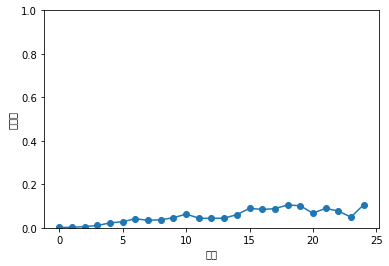

In [0]:


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


7.4 seq2seq 개선

- 입력 데이터 반전
 - https://stackoverflow.com/questions/51003992/why-do-we-reverse-input-when-feeding-in-seq2seq-model-in-tensorflow-tf-reverse

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 4[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 6[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 7[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 8[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 17[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q

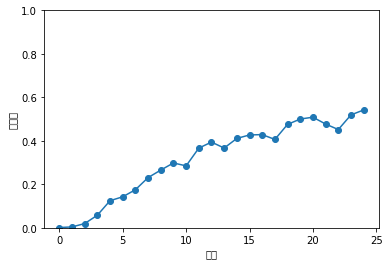

In [0]:

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


- Peeky
 - Encoder -> Decoder 로 전달되는 최초의 h 벡터값을, Decoder 의 다른 계층(LSTM, Affine) 에도 전달해줌
 - 혼합된 입력 벡터를 concat 하여 학습파라미터 사이즈가 늘어나게 된다 

In [0]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # concat dimension
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # concat dimension
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # concat dimension
        out = np.concatenate((hs, out), axis=2) # concat dimension

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2) # concat dimension

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled




- PeekySeq2seq
 - Decoder -> PeekyDecoder  로 교체

In [0]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

- Reverse + Peeky 를 모두 적용한 모델로 재실행

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 18[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---


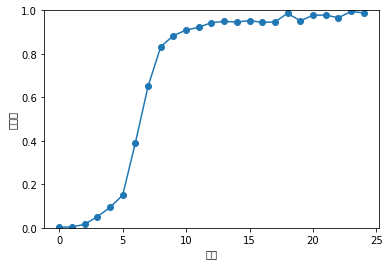

In [0]:
# coding: utf-8


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
#model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


In [0]:
char_to_id

{' ': 5,
 '+': 2,
 '0': 9,
 '1': 0,
 '2': 8,
 '3': 10,
 '4': 12,
 '5': 4,
 '6': 1,
 '7': 3,
 '8': 11,
 '9': 7,
 '_': 6}

In [0]:
x_predict="113+558"
x_predict_input = [char_to_id[c + ""] for c in x_predict]

print(x_predict_input)

result = model.generate(np.array([x_predict_input]), 6, 6)

print(''.join([id_to_char[c] for c in result]))

[0, 0, 10, 2, 4, 4, 11]
1166  


7.5. seq2seq 응용 어플리케이션
- 챗봇
 - https://github.com/tensorlayer/seq2seq-chatbot
- 알고리즘 학습
 - ??
- 이미지 캡셔닝
 - https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning